In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

import os
import cv2

2024-10-15 12:07:14.498480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 12:07:14.578680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 12:07:14.624501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 12:07:14.634157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 12:07:14.693253: I tensorflow/core/platform/cpu_feature_guar

<h2>Model</h2>

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def get_model(image_input_shape):
    """
    Creates a model that takes only image input to predict stable height categories (classification task),
    considering class imbalance and overfitting prevention, using a pretrained model and fine-tuning.
    
    Args:
    - image_input_shape: tuple, the shape of the input image (e.g., (224, 224, 3))
    
    Returns:
    - model: Keras model object
    """

    # Load EfficientNetB0 as a pre-trained model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_input_shape)

    # Fine-tuning: Unfreeze the last few layers of the base model for training
    for layer in base_model.layers[-20:]:
        layer.trainable = True  # Fine-tune only the last 20 layers

    # Freeze the rest of the layers to use their pre-trained weights
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Add custom layers for classification (fine-tuning)
    x = base_model.output
    x = Flatten()(x)  # Flatten the output from the base model
    
    # Add fully connected layers with L2 regularization to prevent overfitting
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    
    # Final output layer (classification output for 7 classes)
    output = Dense(7, activation='softmax')(x)  # 7 classes, use softmax for multi-class classification

    # Build the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model using Categorical Crossentropy as the loss function
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
                  metrics=['accuracy'])

    return model


In [3]:
def load_images_from_folder(folder_path, ids, image_size=(224, 224)):
    images = []
    for id in ids:
        filename = str(int(id)) + '.jpg'

        # Load the image using OpenCV
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        # Resize the image to the target size (224, 224)
        img = cv2.resize(img, image_size)

        # Convert BGR (OpenCV default) to RGB if needed (TensorFlow models use RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to the range [0, 1]
        img_array = img / 255.0

        images.append(img_array)

    # Convert the list of images to a NumPy array with shape (n, 224, 224, 3)
    return np.array(images)

In [4]:
# Fill in the path for the image files
folder_path = '../COMP90086_2024_Project_train/train'

# Load the labels
train = np.genfromtxt(f'{folder_path}.csv', delimiter=',', skip_header=1)
ids = train[:, 0]
labels = np.array(train[:, 6], dtype=int)
adjusted_labels = labels - 1

# Load the images from the folder
image_data = load_images_from_folder(folder_path, ids)



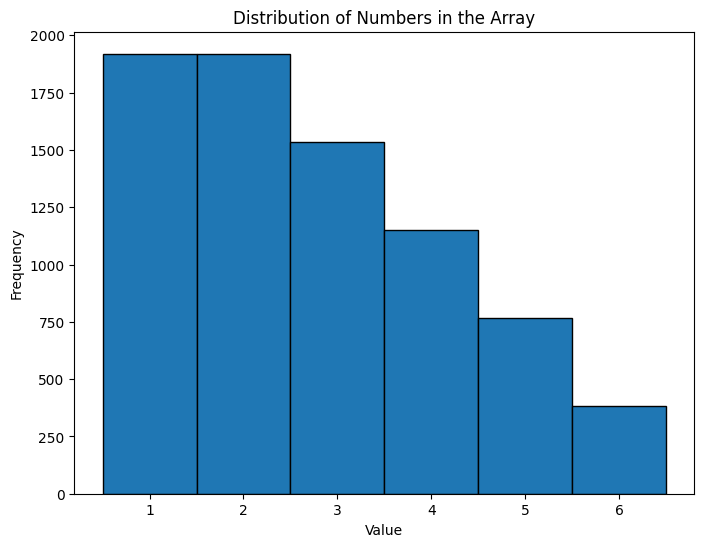

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example array of integers
integer_array = labels

# Generate the bar chart for the distribution
plt.figure(figsize=(8, 6))
plt.hist(integer_array, bins=np.arange(min(integer_array), max(integer_array) + 2) - 0.5, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers in the Array')
plt.xticks(np.arange(min(integer_array), max(integer_array) + 1))

plt.show()

In [6]:
# Define input shapes
image_input_shape = (224, 224, 3)  # Example image size (224x224)

# Build the combined model
model = get_model(image_input_shape)

# Train the model
history = model.fit(
    image_data,  # Input data
    adjusted_labels,  # Target output (stable height)
    epochs=5,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 114s 564ms/step - accuracy: 0.2107 - loss: 2.7935 - val_accuracy: 0.2422 - val_loss: 2.4676
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 98s 509ms/step - accuracy: 0.2345 - loss: 2.4305 - val_accuracy: 0.2422 - val_loss: 2.3183
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 88s 459ms/step - accuracy: 0.2339 - loss: 2.3136 - val_accuracy: 0.2337 - val_loss: 2.2084
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 100s 519ms/step - accuracy: 0.2392 - loss: 2.2105 - val_accuracy: 0.2422 - val_loss: 2.1380
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 103s 537ms/step - accuracy: 0.2479 - loss: 2.1445 - val_accuracy: 0.2337 - val_loss: 2.0795


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


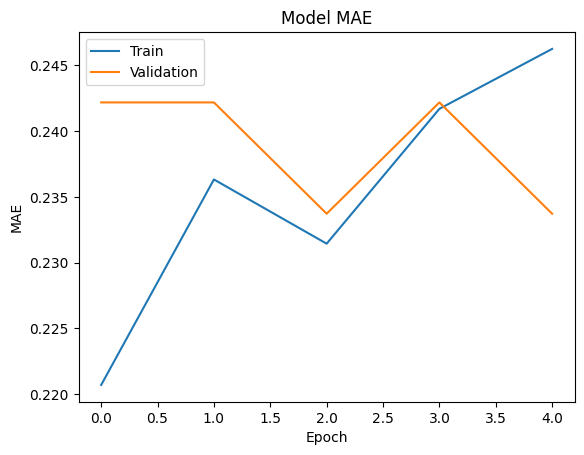

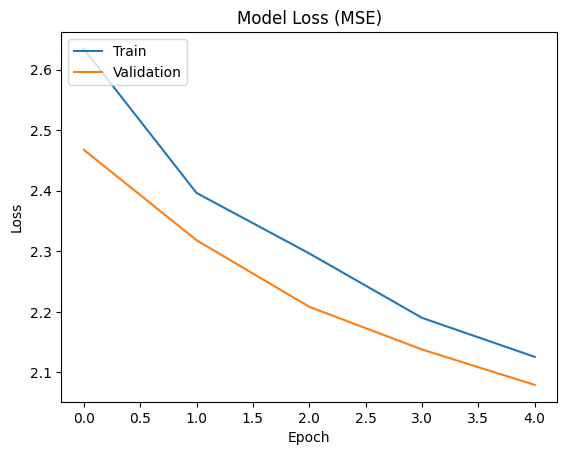

In [10]:
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot training & validation MAE values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values (MSE)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
folder_path = '../COMP90086_2024_Project_test/test'
test = np.genfromtxt('../COMP90086_2024_Project_test/test.csv', delimiter=',', skip_header=1)
ids = np.array(test, dtype=int)
test_image_data = load_images_from_folder(folder_path, ids)

In [9]:
# Predict stable height on the test set
predicted_heights = model.predict(test_image_data)
adjusted_predicted_heights = predicted_heights + 1

60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step


In [11]:
import csv
with open('submission.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(['id', 'stable_height'])
    for i in range(len(ids)):
        submission_writer.writerow([ids[i], int(adjusted_predicted_heights[i][0])])